# Python setup

## Imports

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [64]:
from buildingspy.io.outputfile import Reader

In [65]:
from ipypublish import nb_setup

## Cosmetics


In [66]:
pd = nb_setup.setup_pandas()
pd.set_option('precision', 3)

In [67]:
# https://stackoverflow.com/a/39566040/11552622
rcparams = {
    'axes.titlesize':13,
    'axes.labelsize':9,
    'xtick.labelsize':8,
    'ytick.labelsize':8
}

In [68]:
# IPyPublish customization of matplotlib.pyplot and pandas
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib(output=('pdf','svg'), rcparams=rcparams, usetex=True)

## Path configuration

In [69]:
file_names = {
    # Results summary table
    'table': 'table.csv', 
    # Hemodynamic parameters
    'Xexact': 'Xexact.csv', 'Xpred':'Xpredicted.csv',
    # DNN responses
    'Ytest':'Ytest.txt', 'Ypred':'Ytestpred.txt',
    # Simulation files
    'simulation': 'Ursino1998Model_VAD2_{}_{}.mat'
}

In [70]:
prefix = '/media/maousi/Data/tmp/'
suffix = '/results/'
results_folders = {
    # Boolean: artificial pulse
    False: {
        # Integer: RPM
        4000: 'simulations_2020_03_21',
        5000: 'simulation_LVAD_RPM5000_2020_04_21',
        6000: 'simulation_LVAD_RPM6000_2020_04_22',
        # Convention: put the simulations without LVAD here, i.e. RPM=0
        0:    'simulation_noLVAD_2020_04_15'
    },
    True: {
        # Integer: RPM
        4000: 'simulation_LVAD_RPM4000_Pulse_T30_N2000_2020_04_26',
        5000: 'simulation_LVAD_RPM5000_Pulse_T30_N2000_2020_04_26',
        6000: 'simulation_LVAD_RPM6000_Pulse_T30_N2000_2020_04_26'
        #4000: 'simulation_LVAD_RPM4000_Pulse_T20_N500_2020_05_31',
        #5000: 'simulation_LVAD_RPM5000_Pulse_T20_N500_2020_05_31',
        #6000: 'simulation_LVAD_RPM6000_Pulse_T20_N500_2020_05_31'
    }
}
for ap, dic in results_folders.items():
    for rpm, path in dic.items():
        dic[rpm] = prefix+path+suffix

---

# Color palette & color-blindness

In [71]:
sns.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [72]:
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

---

# Latex generator

## Parameter range

In [73]:
cols = [r'$E_{max,lv}$', r'$E_{max,lv,0}$',
                  r'$G_{E_{max,lv}}$', r'$k_{E,lv}$']
index = ['Lower bound', 'Upper bound']
data = np.array([
    [0.2, 2.95],
    [0.2, 2.392],
    [0.2, 0.475],
    [0.011, 0.014]
]).transpose()

In [74]:
pd.DataFrame(data=data, index=index, columns=cols)

,"$E_{max,lv}$","$E_{max,lv,0}$","$G_{E_{max,lv}}$","$k_{E,lv}$"
Lower bound,0.20,0.200,0.200,0.011
Upper bound,2.95,2.392,0.475,0.014


## DNN results

In [75]:
# Define utility function to format results table
def format_table(table):
    table.index = [
        'Min exact', 'Max exact', 'Mean exact', 'SD exact', 'Min pred', 
        'Max pred', 'Mean pred', 'SD pred', 'Avg err mx', 
        'Avg rel err%', 'SD error', 'CI min', 'CI max',
    ]
    table.columns = [
        'HR','SAPM','SAPS','SAPD', 'PAPM','PAPS','PAPD','LVEF',
        'LVEDV', 'LVESV', 'CI', 'PCPW'
    ]
    # Multiply relative error by 100
    table.loc['Avg rel err%', :] = table.loc['Avg rel err%', :] * 100

In [76]:
# Load the table, format it and return it
def get_results_table(artificial_pulse, RPM):
    """
    :param artificial_pulse: bool
    :param RPM: int
    """
    df = pd.read_csv(
        results_folders[artificial_pulse][RPM] + file_names['table'], 
        header=None
    )
    format_table(df)
    return df

In [77]:
get_results_table(artificial_pulse=True, RPM=4000)

,HR,SAPM,SAPS,SAPD,PAPM,PAPS,PAPD,LVEF,LVEDV,LVESV,CI,PCPW
Min exact,62.500,75.432,89.977,68.160,15.301,26.609,9.646,29.833,126.304,34.254,0.421,4.998
Max exact,78.431,101.865,133.694,86.240,23.131,31.407,18.993,74.625,209.397,146.796,1.892,15.687
Mean exact,67.075,92.573,119.839,78.940,17.766,28.191,12.554,56.378,153.906,68.760,-1.513,8.420
SD exact,3.459,6.012,9.717,4.253,1.588,1.005,1.886,10.147,17.231,23.601,0.313,2.185
Min pred,62.500,75.669,90.091,68.458,15.199,26.596,9.499,28.961,128.436,34.356,0.457,4.851
Max pred,78.431,102.156,133.942,86.262,23.075,31.401,18.911,74.607,211.723,148.634,1.900,15.415
Mean pred,67.134,92.476,119.587,78.921,17.760,28.189,12.546,56.474,154.791,69.161,-1.504,8.434
SD pred,3.650,6.307,10.239,4.426,1.647,1.037,1.958,10.678,18.068,24.819,0.329,2.272
Avg err mx,0.546,0.612,1.023,0.486,0.144,0.096,0.171,1.606,2.186,3.188,0.032,0.193
Avg rel err%,0.805,0.681,0.894,0.627,0.787,0.336,1.308,2.950,1.362,4.782,2.609,2.211


In [78]:
def format_table_article(art_pulse, RPM):
    # TODO : check multicolumn param of to_latex !!!! and many other params
    df = get_results_table(artificial_pulse=art_pulse, RPM=RPM)
    return df.to_latex(caption=f'{art_pulse}, {RPM}', bold_rows=True, 
                       float_format='%.2f', escape=True)

In [79]:
format_table_article(True,4000)

'\\begin{table}\n\\centering\n\\caption{True, 4000}\n\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} &    HR &   SAPM &   SAPS &  SAPD &  PAPM &  PAPS &  PAPD &  LVEF &  LVEDV &  LVESV &    CI &  PCPW \\\\\n\\midrule\n\\textbf{Min exact   } & 62.50 &  75.43 &  89.98 & 68.16 & 15.30 & 26.61 &  9.65 & 29.83 & 126.30 &  34.25 &  0.42 &  5.00 \\\\\n\\textbf{Max exact   } & 78.43 & 101.87 & 133.69 & 86.24 & 23.13 & 31.41 & 18.99 & 74.63 & 209.40 & 146.80 &  1.89 & 15.69 \\\\\n\\textbf{Mean exact  } & 67.08 &  92.57 & 119.84 & 78.94 & 17.77 & 28.19 & 12.55 & 56.38 & 153.91 &  68.76 & -1.51 &  8.42 \\\\\n\\textbf{SD exact    } &  3.46 &   6.01 &   9.72 &  4.25 &  1.59 &  1.00 &  1.89 & 10.15 &  17.23 &  23.60 &  0.31 &  2.19 \\\\\n\\textbf{Min pred    } & 62.50 &  75.67 &  90.09 & 68.46 & 15.20 & 26.60 &  9.50 & 28.96 & 128.44 &  34.36 &  0.46 &  4.85 \\\\\n\\textbf{Max pred    } & 78.43 & 102.16 & 133.94 & 86.26 & 23.07 & 31.40 & 18.91 & 74.61 & 211.72 & 148.63 &  1.90 & 15.41 \\\\\n\\textbf{

In [80]:
from datetime import datetime

In [81]:
configs = [(True, 4000), (True, 5000), (True, 6000), (False, 4000),
           (False, 5000), (False, 6000)]

data = '\n'.join([format_table_article(*config) for config in configs])

In [82]:
header = '%\n% AUTOMATICALLY GENERATED - ' + datetime.now().strftime('%d-%m-%Y %H:%M:%S')
header += '\n% Notebook : N13 Article Utility\n%\n\n'
with open('data/dnn_hemodynamic_tables.tex', 'w') as f:
    f.write(header + data)

# Get a visual

## Normalization

In [83]:
#import sys
#import scipy.io as sio

#sys.path.insert(0, '../Simulation_script/')

#%run ../Deep_learning/utils_deeplearning.py

#X = sio.loadmat('/media/maousi/Data/tmp/dnntest/X.mat')['X']

#X.shape

#plt.hist(X[0, 0])

#ncoeff, nfreq = X.shape[1], X.shape[2]

#newmins = np.full([ncoeff, nfreq], 0.0)
#newmaxs = np.full([ncoeff, nfreq], 1.0)

#%%capture cap_out
#Xnorm, _, _ = normalizeinputmatDL(X, newmins, newmaxs);

#plt.hist(Xnorm[0, 0])

# Figures



## SHF simulations

In [84]:
sns.set(style='whitegrid')

In [85]:
# Define: variables to load
variables = ['SystemicArteries.PC', 'AorticValve.Inlet.Q',
             'SystemicArteries.Inlet.Q', 'LVAD.RPM', 'LeftVentricle.Inlet.P']
# Define folder
folder_standalone_sim = '/media/maousi/Raw/standalone/'

In [86]:
# Data structure: nested dictionnaries
# level 1 = heart failure, level 2 = rpm
data_sim = {
    hf_level: {rpm: None for rpm in [4000, 5000, 6000]}
    for hf_level in ['SHF']#['MHF', 'SHF']
}

In [87]:
def time_range(tmin, tmax, t, signal):
    ids = np.where(np.logical_and(t >= tmin, t <= tmax))
    return t[ids], signal[ids]

def read_simulations(path, file_format, data, variables, tmin, tmax):
    for hf_level, subdata in data.items():
        for rpm in subdata:
            file = path + file_format.format(hf_level, rpm)
            reader = Reader(file, 'dymola')
            subdata[rpm] = [
                time_range(tmin, tmax, *reader.values(v)) for v in variables
            ]

In [88]:
read_simulations(
    path=folder_standalone_sim, file_format='Ursino1998Model_VAD2_{}_{}.mat',
    data=data_sim, variables=variables, tmin=26.0, tmax=30.0
)

In [113]:
# We have 2 heart failure levels * 3 rpm levels = 6 simulations
# The function handles data for a given heart failure level
def plot_simulations(data_hf):
    fig, ax = plt.subplots(len(data_hf), 1, figsize=(10, 10))

    for i, (rpm_c, data) in enumerate(data_hf.items()):
        ax1 = ax[i]
        ax2 = ax1.twinx()

        (t1, pressure), (t2, valve_flow), (t3, aortic_flow), (t4, rpm), (t5, lv_pressure) = data
        #(t1, pressure), (t2, valve_flow), (t3, arotic_flow), (t4, rpm) = data[0], data[1], data[2], data[3]
        ax1.plot(t4, rpm/100, 'k--', linewidth=1)
        ax1.plot(t1, pressure, 'b')
        ax1.plot(t1, lv_pressure, '--', linewidth=0.8)
        ax2.plot(t2, valve_flow, 'r--', linewidth=1)
        ax2.plot(t3, aortic_flow, 'r', linewidth=1)
        #ax2.set_ylim([min(flow)-25, max(flow)+25])
        #ax1.set_ylim(-5, max(max(pressure), max(flow)))
        #ax2.plot(t2, flow)

        # Manage x axis
        if i == 2:
            ax1.set_xlabel('Time [s]')
        else:
            pass#ax1.set_xticks([])
        
        ax1.set_ylabel('Systemic pressure [mmHg]\nLV pressure [mmHg]\nPump speed [RPM/100]')
        ax2.set_ylabel('Aortic flow [ml/s]\nValve flow [ml/s]')
        #ax1.yaxis.label.set_color('b')
        # Align the grids
        #ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks())))
        ax2.grid(False)
        ax2.set_ylim([-5, 1.5*max(aortic_flow)])
        #ax1.set_title('RPM mean = {}'.format(rpm_c))

    plt.subplots_adjust(hspace=.2)

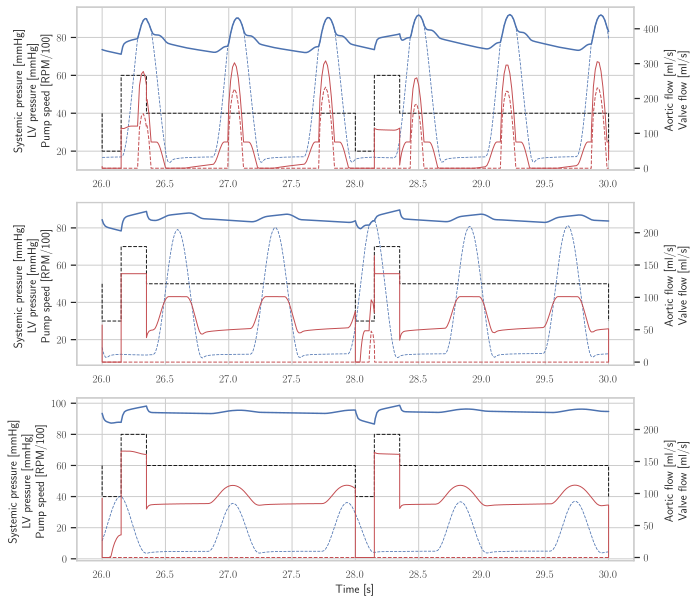

In [114]:
plot_simulations(data_sim['SHF'])
plt.savefig('figs/SHF_simulations.eps')

In [427]:
pal = sns.color_palette('colorblind', n_colors=4)
red = pal[3]
blue = pal[0]
green = pal[2]
pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0)]

In [437]:
def plot_simulations2(data_hf):
    def make_patch_spines_invisible(ax):
        ax.set_frame_on(True)
        ax.patch.set_visible(False)
        for sp in ax.spines.values():
            sp.set_visible(False)
    
    def setup_secondary_axis(ax, ax_position):
        # Put the axis on the left-hand side (instead of right)
        ax.spines["left"].set_position(("axes", ax_position))
        make_patch_spines_invisible(ax)
        ax.spines["left"].set_visible(True)
        ax.yaxis.set_label_position('left')
        ax.yaxis.set_ticks_position('left')
        ax.grid(False)
        
    def align_yaxis(ax1, v1, ax2, v2):
        """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
        _, y1 = ax1.transData.transform((0, v1))
        _, y2 = ax2.transData.transform((0, v2))
        inv = ax2.transData.inverted()
        _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
        miny, maxy = ax2.get_ylim()
        ax2.set_ylim(miny+dy, maxy+dy)

    # Loop over the items in data_hf
    fig, axes = plt.subplots(len(data_hf), 1, figsize=(10, 10), sharey=True)
    
    # Generate 2 new vertical axes
    axes2 = [ax.twinx() for ax in axes]
    axes3 = [ax.twinx() for ax in axes]
    # Setup secondary and tertiary axes
    position_step = -.1
    for i, ax in enumerate(axes2 + axes3):
        ax_position = 2*position_step if i < len(axes2) else position_step
        setup_secondary_axis(ax, ax_position)
    axes2[0].get_shared_y_axes().join(*axes2)
    axes3[0].get_shared_y_axes().join(*axes3)
        
    # Share secondary axes
    for i, (rpm_c, data) in enumerate(data_hf.items()):

        # Get curves data
        (t1, pressure), (t2, valve_flow), (t3, aortic_flow), (t4, rpm), (t5, lv_pressure) = data
        for t in [t1, t2, t3, t4, t5]:
            t -= t.min()
        
        # Create several vertical axes
        ax1 = axes[i]
        ax2 = axes2[i]
        ax3 = axes3[i]
        
        # Plot
        l1, = ax2.plot(t4, rpm, 'k--', linewidth=1, zorder=1)
        l2, = ax1.plot(t1, pressure, color=blue)
        l3, = ax1.plot(t1, lv_pressure, '--', color=blue, linewidth=1)
        l4, = ax3.plot(t3, aortic_flow, color=red)
        l5, = ax3.plot(t2, valve_flow, '--', color=green, linewidth=1)
        # Put ax1 in front (zorder)
        #ax1.set_zorder(ax1.get_zorder()+2.5)
        #ax1.patch.set_visible(False)
        #for l in ax1.yaxis.get_ticklines():
        #    l.set_zorder(1)

        # Labels
        if i == 2:
            ax1.set_xlabel('Time [s]')
        ax1.set_ylabel('SAP, LV pressure [mmHg]')
        ax3.set_ylabel('Aortic and valve flow [mL/s]')
        ax2.set_ylabel('Pump speed [RPM]')

    
    # Z order - for some reason, doesn't work if this is done somewhere else
    #axes[0].grid(zorder=0)
    #axes[1].grid(zorder=0)
    #axes[2].grid(zorder=0)
    
    align_yaxis(axes[0], 0, axes2[0], 0)
    
    # Whole plot adjustments
    plt.subplots_adjust(hspace=.2)
    # Legend under the plot
    ax2.legend(handles = [l1,l2,l3, l4, l5], labels=['LVAD speed', 'SAP', 'LV pressure', 'Aortic flow', 'Aortic valve flow'], 
               bbox_to_anchor=(0.5, -.35), fancybox=False, shadow=False, ncol=5, loc='center')
    #plt.tight_layout()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


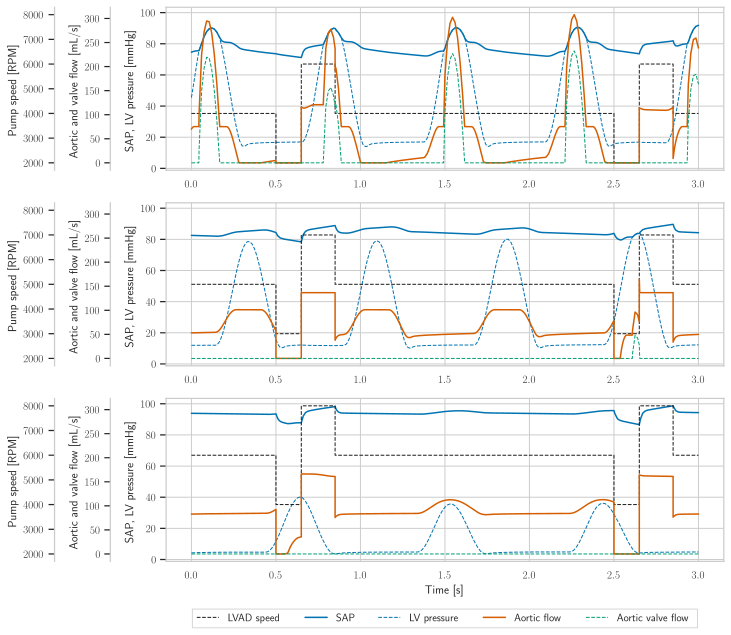

In [438]:
read_simulations(
    path=folder_standalone_sim, file_format='Ursino1998Model_VAD2_{}_{}.mat',
    data=data_sim, variables=variables, tmin=25.5, tmax=28.5
)

plot_simulations2(data_sim['SHF'])
plt.savefig('figs/SHF_simulations_enhanced.eps', bbox_inches='tight')
plt.savefig('figs/SHF_simulations_enhanced.jpg', bbox_inches='tight')

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

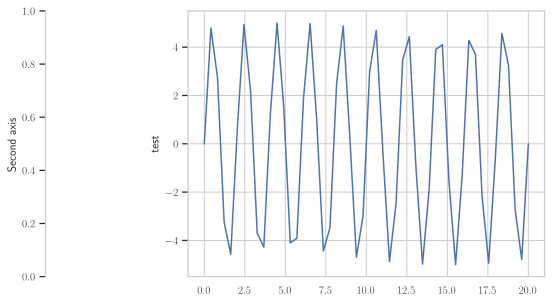

In [278]:
t = np.linspace(0, 20, 50)
y = np.sin(2*np.pi*0.5*t) * 5
w = t - t**2 / 10 + 3
plt.plot(t, y)
plt.ylabel('test')

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

a = plt.gca().twinx()
a.set_ylabel('Second axis')

a.spines["left"].set_position(("axes", -0.4)) # red one

make_patch_spines_invisible(a)

a.spines["left"].set_visible(True)
a.yaxis.set_label_position('left')
a.yaxis.set_ticks_position('left')
dir(a.grid())

In [146]:
a.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x7fb76eb19210>),
             ('right', <matplotlib.spines.Spine at 0x7fb76eb19550>),
             ('bottom', <matplotlib.spines.Spine at 0x7fb76eb19190>),
             ('top', <matplotlib.spines.Spine at 0x7fb76e98e090>)])

In [ ]:
plt.

### Compare pressure 


### Compute metrics

In [93]:
shf = data_sim['SHF']

In [94]:
# get_sap returns (t, pressure)
get_sap = lambda datastruct, rpm: datastruct[rpm][0]

In [95]:
# Mean SAP


## DNN accuarcy

### Effect of artificial pulse

In [96]:
Ymse = pickle.load(open('data/dnn_mse.bin', 'rb'))

In [97]:
Ymse

Parameter               Emax  Emax0     G_Emax        k_E
RPM  Artificial Pulse                                    
0    False             0.009  0.007  1.996e-03  2.604e-08
4000 False             0.011  0.006  1.854e-03  1.250e-08
     True              0.017  0.010  3.327e-03  4.002e-08
5000 False             0.014  0.007  2.771e-03  2.662e-08
     True              0.030  0.010  4.705e-03  3.635e-08
6000 False             0.009  0.003  8.265e-04  2.916e-08
     True              0.022  0.006  2.848e-03  1.269e-08

In [98]:
Ymse.index

MultiIndex([(   0, False),
            (4000, False),
            (4000,  True),
            (5000, False),
            (5000,  True),
            (6000, False),
            (6000,  True)],
           names=['RPM', 'Artificial Pulse'])

In [99]:
YmseT = Ymse.transpose()
YmseT

RPM                    0          4000                  5000             \
Artificial Pulse      False      False      True       False      True    
Parameter                                                                 
Emax              8.973e-03  1.121e-02  1.705e-02  1.405e-02  3.042e-02   
Emax0             7.464e-03  6.052e-03  9.693e-03  7.078e-03  9.601e-03   
G_Emax            1.996e-03  1.854e-03  3.327e-03  2.771e-03  4.705e-03   
k_E               2.604e-08  1.250e-08  4.002e-08  2.662e-08  3.635e-08   

RPM                    6000             
Artificial Pulse      False      True   
Parameter                               
Emax              8.550e-03  2.163e-02  
Emax0             3.071e-03  5.809e-03  
G_Emax            8.265e-04  2.848e-03  
k_E               2.916e-08  1.269e-08

In [100]:
rpms = [4000, 5000, 6000]
columns = pd.Index(name='RPM', data=rpms)
artpulse_error = pd.DataFrame(columns=columns, index=YmseT.index)
for rpm in rpms:
    # Compute MSE relative increase of each param for each rpm
    percincrease = (YmseT[(rpm, True)] - YmseT[(rpm, False)])/YmseT[(rpm, False)] * 100
    artpulse_error.loc[:, rpm] = percincrease

In [101]:
artpulse_error

RPM,4000,5000,6000
Parameter,,,
Emax,52.045,116.493,152.950
Emax0,60.151,35.653,89.135
G_Emax,79.436,69.756,244.644
k_E,220.036,36.540,-56.469


In [102]:
artpulse_error.apply(np.mean, axis=1)

Parameter
Emax      107.163
Emax0      61.647
G_Emax    131.279
k_E        66.703
dtype: float64

### Effect of LVAD presence

In [103]:
Ymse.drop((0, False)).apply(np.mean)

Parameter
Emax      1.715e-02
Emax0     6.884e-03
G_Emax    2.722e-03
k_E       2.623e-08
dtype: float64

## HEmodynamic quantities

In [104]:
X = pd.read_csv('data/hemodynamic_test_data.csv')

In [105]:
X

,HR,SAPM,SAPS,SAPD,PAPM,PAPS,PAPD,LVEF,LVEDV,LVESV,...,PAPM_hat,PAPS_hat,PAPD_hat,LVEF_hat,LVEDV_hat,LVESV_hat,CI_hat,PCPW_hat,RPM,art_pulse
0,65.217,90.854,122.580,74.990,18.246,29.197,12.771,58.167,142.950,59.800,...,18.118,28.990,12.681,58.834,141.976,58.446,2.063,8.682,4000,False
1,62.500,94.703,126.596,78.756,16.719,28.000,11.079,57.532,158.079,67.133,...,16.661,28.008,10.988,58.473,156.195,64.862,2.123,6.812,4000,False
2,65.217,92.610,126.436,75.697,18.193,29.000,12.789,54.782,149.251,67.488,...,18.173,28.960,12.779,54.440,150.272,68.464,2.194,8.471,4000,False
3,62.500,93.789,126.442,77.463,17.357,28.540,11.765,58.570,148.720,61.615,...,17.189,28.380,11.593,58.966,149.552,61.367,2.050,7.450,4000,False
4,62.500,94.979,128.960,77.988,17.526,28.487,12.045,53.209,162.688,76.124,...,17.491,28.581,11.945,54.271,161.838,74.006,2.237,7.393,4000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,69.491,93.457,108.761,85.805,13.949,25.756,8.046,60.591,100.598,39.644,...,13.959,25.767,8.055,60.623,99.711,39.264,0.221,3.251,6000,True
3496,68.966,91.272,103.407,85.205,14.346,25.926,8.556,58.167,97.376,40.735,...,14.262,25.926,8.429,57.015,94.254,40.516,0.139,3.645,6000,True
3497,70.001,95.298,112.015,86.940,13.787,25.696,7.832,68.128,98.478,31.387,...,13.756,25.686,7.790,69.027,97.801,30.292,0.332,2.993,6000,True
3498,63.492,89.436,99.404,84.453,14.889,26.153,9.257,57.425,109.132,46.463,...,14.905,26.169,9.273,57.521,108.971,46.289,0.000,4.435,6000,True


In [106]:
X.columns

Index(['HR', 'SAPM', 'SAPS', 'SAPD', 'PAPM', 'PAPS', 'PAPD', 'LVEF', 'LVEDV',
       'LVESV', 'CI', 'PCPW', 'HR_hat', 'SAPM_hat', 'SAPS_hat', 'SAPD_hat',
       'PAPM_hat', 'PAPS_hat', 'PAPD_hat', 'LVEF_hat', 'LVEDV_hat',
       'LVESV_hat', 'CI_hat', 'PCPW_hat', 'RPM', 'art_pulse'],
      dtype='object')

In [107]:
# Relative errors
E = X.loc[:, ['RPM', 'art_pulse'] + [col for col in X.columns if '_relerr' in col]]

In [108]:
E

,RPM,art_pulse
0,4000,False
1,4000,False
2,4000,False
3,4000,False
4,4000,False
...,...,...
3495,6000,True
3496,6000,True
3497,6000,True
3498,6000,True


### Mean relative errors

In [109]:
E

,RPM,art_pulse
0,4000,False
1,4000,False
2,4000,False
3,4000,False
4,4000,False
...,...,...
3495,6000,True
3496,6000,True
3497,6000,True
3498,6000,True


In [110]:
E = E.groupby(['RPM', 'art_pulse']).mean().rename({
    col: col.split('_')[0] for col in E.columns[2:]
}, axis=1)

DataError: No numeric types to aggregate

In [ ]:
E.index.rename(['RPM', 'Art. Pulse'], inplace=True)

In [ ]:
pd.set_option('precision', 2)

In [ ]:
E

### Mean

In [ ]:
Xmean = X.loc[:, [c for c in X.columns if '_relerr' in c]].mean()
Xmean

### Median

In [ ]:
Xmed = X.loc[:, [c for c in X.columns if '_relerr' in c]].median()
Xmed

In [ ]:
pd.DataFrame([Xmean, Xmed]).transpose().rename({0:'Mean', 1:'Median'}, axis=1)

### Describe

In [ ]:
X.loc[:, [c for c in X.columns if '_relerr' in c]].describe().transpose()

### Effect of artificial pulse

In [ ]:
AP_data_ = E.drop('CI', axis=1).drop((0, False))
AP_data_

In [ ]:
AP_data = pd.DataFrame(index=AP_data_.columns)
for rpm in [4000,5000,6000]:
    diff = AP_data_.loc[(rpm, True), :] - AP_data_.loc[(rpm, False), :]
    AP_data[rpm] = diff / AP_data_.loc[(rpm, True), :] * 100

In [ ]:
AP_data

In [ ]:
AP_data.mean()

### Effet of RPMs when artificial pulse is active

In [ ]:
RPM = X.loc[X.art_pulse == True, ['RPM'] + [c for c in X.columns if '_relerr' in c]].groupby('RPM').mean()
RPM

### Effect of RPM when artificial pulse is NOT active

In [ ]:
RPM = X.loc[X.art_pulse == False, ['RPM'] + [c for c in X.columns if '_relerr' in c]].groupby('RPM').mean()
RPM